# Assignment 4 — Build Non-Linear Models (Part 2)

This notebook completes:
1. **Conceptual Question #3** (ISLR Python, p. 326)
2. **Applied Question #8** (ISLR Python, p. 327) using the **Auto** data set
3. **Kaggle: Regression with Abalone Dataset** — two non-linear regression models, diagnostics, and a Kaggle submission file

References used for methodology and interpretation include *An Introduction to Statistical Learning* (James et al., 2021), classic Exploratory Data Analysis principles (Tukey, 1977), and missing-data handling guidance (Little & Rubin, 2019).


## 0. Imports and Helper Functions


In [1]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import scipy.stats as stats

pd.set_option("display.max_columns", 200)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def diagnostic_plots(y_true, y_pred, title_prefix="Model"):
    resid = y_true - y_pred

    plt.figure()
    plt.scatter(y_pred, resid, alpha=0.5)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix}: Residuals vs Fitted")
    plt.show()

    plt.figure()
    stats.probplot(resid, dist="norm", plot=plt)
    plt.title(f"{title_prefix}: Q–Q Plot of Residuals")
    plt.show()


## 1. Conceptual Question #3 (ISLR p. 326)
We are given basis functions:
\[
b_1(X)=X,\quad b_2(X)=(X-1)^2 I(X\ge 1)
\]
and fitted coefficients \(\hat\beta_0=1\), \(\hat\beta_1=1\), \(\hat\beta_2=-2\).

### 1.1 Piecewise fitted function
- For \(X<1\): \(\hat Y = 1 + X\)
- For \(X\ge 1\): \(\hat Y = 1 + X - 2(X-1)^2\)

The function is continuous at \(X=1\) and becomes concave downward for \(X\ge 1\) due to the negative quadratic term.


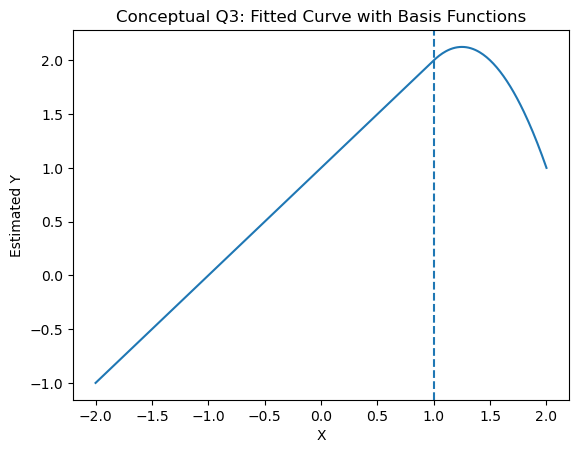

X = -2:  Y_hat = -1.0000
X =  1:  Y_hat = 2.0000
X =  2:  Y_hat = 1.0000


In [2]:

X_grid = np.linspace(-2, 2, 400)

def y_hat(x):
    return 1 + x + (-2) * ((x - 1) ** 2) * (x >= 1)

Y_grid = np.array([y_hat(x) for x in X_grid])

plt.figure()
plt.plot(X_grid, Y_grid)
plt.axvline(1, linestyle="--")
plt.xlabel("X")
plt.ylabel("Estimated Y")
plt.title("Conceptual Q3: Fitted Curve with Basis Functions")
plt.show()

for val in [-2, 1, 2]:
    print(f"X = {val:>2}:  Y_hat = {y_hat(val):.4f}")


## 2. Applied Question #8 (ISLR p. 327): Auto Data Set
This section investigates whether **non-linear** relationships are present by comparing a baseline linear model to a non-linear alternative. Model comparison and residual diagnostics follow standard predictive modeling practice as discussed in ISLR (James et al., 2021).

### 2.1 Load Auto using statsmodels
The Auto data are loaded via `statsmodels.datasets.get_rdataset`, which downloads the dataset.


In [3]:

import statsmodels.api as sm

auto = sm.datasets.get_rdataset("Auto", "ISLR").data.copy()
auto.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
rownames,,,,,,,,,
1,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
2,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
3,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
4,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
5,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### 2.2 Data preparation and EDA checks
EDA is used to validate variable types, ranges, and missingness (Tukey, 1977). If missing data exist, imputation is incorporated into the modeling pipeline to ensure consistent preprocessing (Little & Rubin, 2019).


In [4]:

auto.info()
auto.describe(include="all").T.head(20)


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 1 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 30.6+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mpg,392.0,NaN,NaN,NaN,23.445918,7.805007,9.0,17.0,22.75,29.0,46.6
cylinders,392.0,NaN,NaN,NaN,5.471939,1.705783,3.0,4.0,4.0,8.0,8.0
displacement,392.0,NaN,NaN,NaN,194.41199,104.644004,68.0,105.0,151.0,275.75,455.0
horsepower,392.0,NaN,NaN,NaN,104.469388,38.49116,46.0,75.0,93.5,126.0,230.0
weight,392.0,NaN,NaN,NaN,2977.584184,849.40256,1613.0,2225.25,2803.5,3614.75,5140.0
acceleration,392.0,NaN,NaN,NaN,15.541327,2.758864,8.0,13.775,15.5,17.025,24.8
year,392.0,NaN,NaN,NaN,75.979592,3.683737,70.0,73.0,76.0,79.0,82.0
origin,392.0,NaN,NaN,NaN,1.576531,0.805518,1.0,1.0,1.0,2.0,3.0
name,392,301,amc matador,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:

missing = auto.isna().sum().sort_values(ascending=False)
missing[missing > 0]


Series([], dtype: int64)

### 2.3 Linear vs non-linear model comparison (mpg as the target)
The baseline model is linear regression. The non-linear alternative uses polynomial features on numeric predictors with ridge regularization, providing a controlled way to introduce curvature while managing multicollinearity among expanded terms (James et al., 2021).


Linear RMSE: 2.9181334372549026
Linear R^2 : 0.8331621189043535


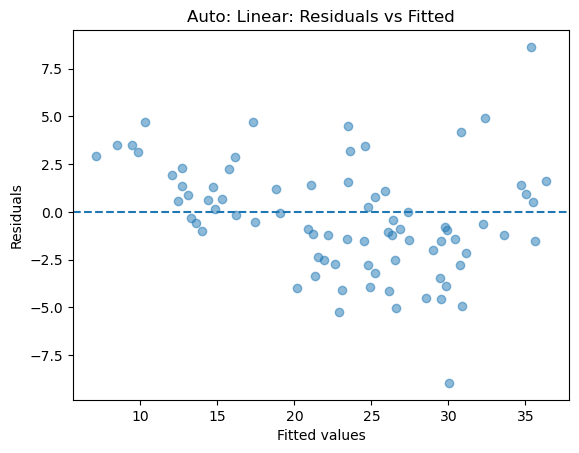

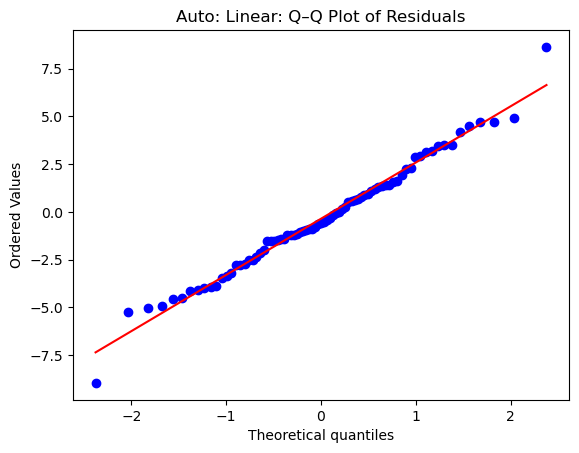

In [6]:

target = "mpg"
df = auto.dropna(subset=[target]).copy()

# Coerce horsepower if stored as object
if "horsepower" in df.columns:
    df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")

X = df.drop(columns=[target])
y = df[target]

# Drop high-cardinality 'name' for modeling
if "name" in X.columns:
    X = X.drop(columns=["name"])

categorical = [c for c in ["origin", "cylinders"] if c in X.columns]
numeric = [c for c in X.columns if c not in categorical]

numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric),
    ("cat", cat_pipe, categorical)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

print("Linear RMSE:", rmse(y_test, pred_lin))
print("Linear R^2 :", r2_score(y_test, pred_lin))
diagnostic_plots(y_test, pred_lin, "Auto: Linear")


Poly(2)+Ridge RMSE: 2.6094162164032375
Poly(2)+Ridge R^2 : 0.8665953138029592


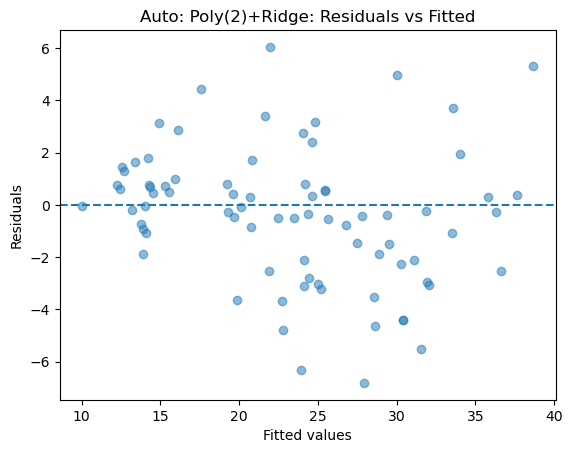

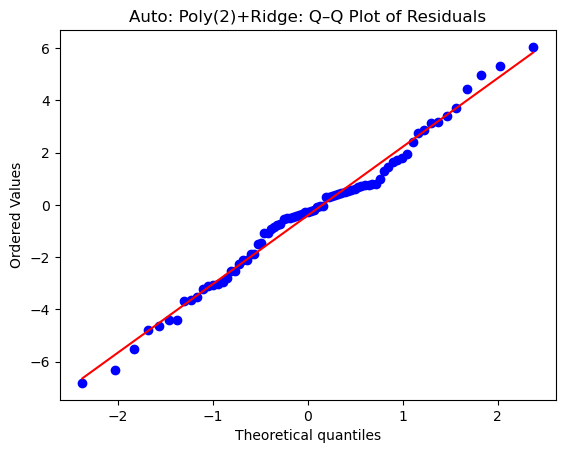

In [7]:

numeric_poly_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler())
])

preprocess_poly = ColumnTransformer([
    ("num", numeric_poly_pipe, numeric),
    ("cat", cat_pipe, categorical)
])

poly_ridge = Pipeline([
    ("prep", preprocess_poly),
    ("model", Ridge(alpha=1.0, random_state=42))
])

poly_ridge.fit(X_train, y_train)
pred_poly = poly_ridge.predict(X_test)

print("Poly(2)+Ridge RMSE:", rmse(y_test, pred_poly))
print("Poly(2)+Ridge R^2 :", r2_score(y_test, pred_poly))
diagnostic_plots(y_test, pred_poly, "Auto: Poly(2)+Ridge")


**Interpretation:** If the polynomial model reduces RMSE and residual structure relative to the linear model, this supports the presence of non-linear relationships in the Auto data (James et al., 2021).


## 3. Kaggle: Regression with Abalone Dataset
Two non-linear models are trained and compared using 5-fold cross-validation and a holdout split:
1. **Polynomial(2)+Ridge** (parametric non-linearity)
2. **Gradient Boosting Regressor** (non-parametric non-linearity)

Missing values are handled inside pipelines using imputation strategies consistent with standard practice (Little & Rubin, 2019).


In [8]:

train_ab = pd.read_csv("train.csv")
test_ab  = pd.read_csv("test.csv")

# Target and features
y_ab = train_ab["Rings"]
X_ab = train_ab.drop(columns=["Rings"])

# Drop identifier from modeling features
X_ab_model = X_ab.drop(columns=["id"])
test_ab_model = test_ab.drop(columns=["id"])

categorical_ab = [c for c in X_ab_model.columns if X_ab_model[c].dtype == "object"]
numeric_ab = [c for c in X_ab_model.columns if c not in categorical_ab]

print("Categorical:", categorical_ab)
print("Numeric:", numeric_ab)


Categorical: ['Sex']
Numeric: ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']


In [9]:

# Common categorical encoder
cat_pipe_ab = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Model 1: Polynomial(2)+Ridge
num_poly_ab = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler())
])

prep_poly_ab = ColumnTransformer([
    ("num", num_poly_ab, numeric_ab),
    ("cat", cat_pipe_ab, categorical_ab)
])

model1 = Pipeline([
    ("prep", prep_poly_ab),
    ("model", Ridge(alpha=1.0, random_state=42))
])

neg_mse = cross_val_score(model1, X_ab_model, y_ab, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
rmse1 = np.sqrt(-neg_mse)
print("Model 1 (Poly2+Ridge) CV RMSE:", rmse1.mean(), "+/-", rmse1.std())


Model 1 (Poly2+Ridge) CV RMSE: 1.9177619834507262 +/- 0.020396721623798082


In [10]:

# Model 2: Gradient Boosting Regressor
prep_basic_ab = ColumnTransformer([
    ("num", Pipeline([("impute", SimpleImputer(strategy="median"))]), numeric_ab),
    ("cat", cat_pipe_ab, categorical_ab)
])

model2 = Pipeline([
    ("prep", prep_basic_ab),
    ("model", GradientBoostingRegressor(random_state=42))
])

neg_mse = cross_val_score(model2, X_ab_model, y_ab, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
rmse2 = np.sqrt(-neg_mse)
print("Model 2 (GBR) CV RMSE:", rmse2.mean(), "+/-", rmse2.std())


Model 2 (GBR) CV RMSE: 1.8830471895309238 +/- 0.023509760836868388


### 3.1 Holdout evaluation and model comparison table


In [11]:

X_tr, X_va, y_tr, y_va = train_test_split(X_ab_model, y_ab, test_size=0.2, random_state=42)

model1.fit(X_tr, y_tr)
pred1 = model1.predict(X_va)

model2.fit(X_tr, y_tr)
pred2 = model2.predict(X_va)

results = pd.DataFrame({
    "Model": ["Polynomial(2)+Ridge", "Gradient Boosting"],
    "CV_RMSE_mean": [rmse1.mean(), rmse2.mean()],
    "CV_RMSE_sd": [rmse1.std(), rmse2.std()],
    "Holdout_RMSE": [rmse(y_va, pred1), rmse(y_va, pred2)],
    "Holdout_R2": [r2_score(y_va, pred1), r2_score(y_va, pred2)]
})

results


,Model,CV_RMSE_mean,CV_RMSE_sd,Holdout_RMSE,Holdout_R2
0,Polynomial(2)+Ridge,1.917762,0.020397,1.947983,0.630597
1,Gradient Boosting,1.883047,0.023510,1.918874,0.641555


### 3.2 Assumption checks (diagnostic plots)
Residuals vs Fitted helps detect remaining functional-form issues and heteroskedasticity; Q–Q plots evaluate whether residuals are approximately normal.


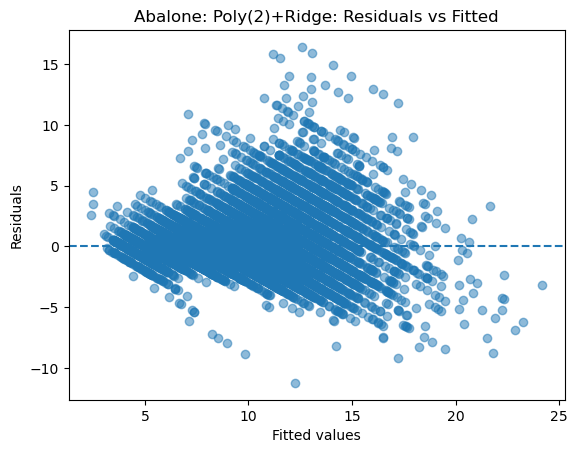

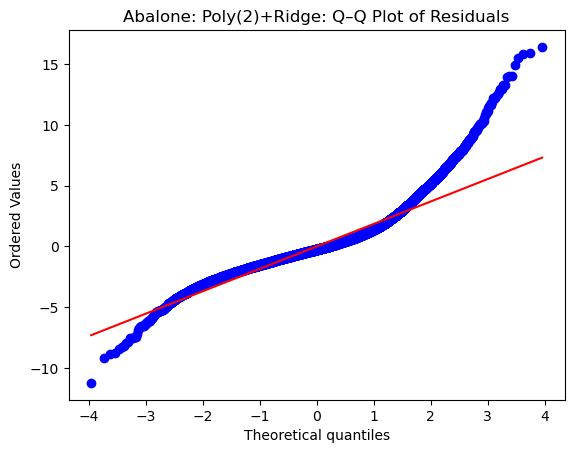

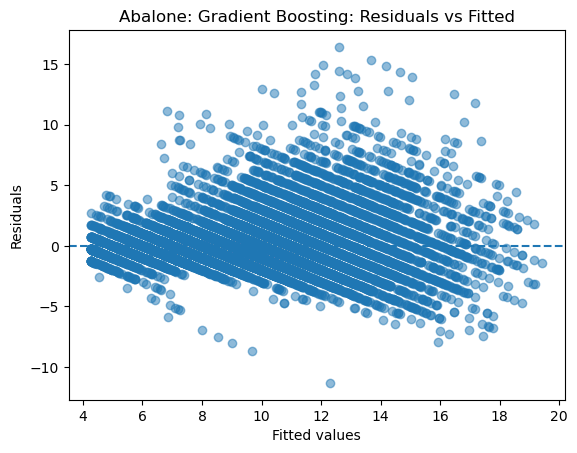

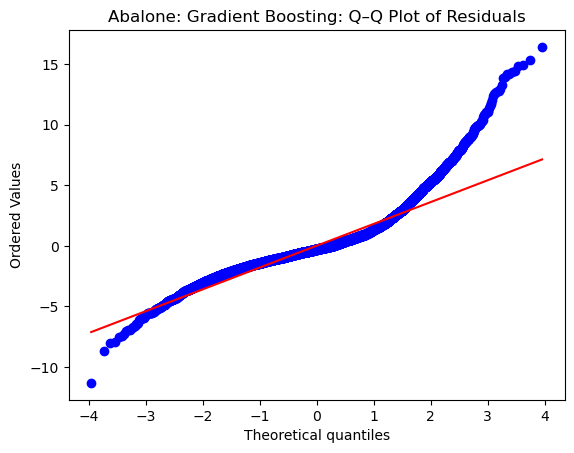

In [12]:

diagnostic_plots(y_va, pred1, "Abalone: Poly(2)+Ridge")
diagnostic_plots(y_va, pred2, "Abalone: Gradient Boosting")


### 3.3 Train final model and create Kaggle submission
Use the model with the best CV RMSE (typically the Gradient Boosting model here), train on the full training set, and predict test set.


In [13]:

best_model = model2  # change to model1 if your CV results are better for model1

best_model.fit(X_ab_model, y_ab)
test_preds = best_model.predict(test_ab_model)

submission = pd.DataFrame({
    "id": test_ab["id"],
    "Rings": test_preds
})
submission.to_csv("submission.csv", index=False)

submission.head()


,id,Rings
0,90615,9.447814
1,90616,9.753562
2,90617,10.295472
3,90618,10.278244
4,90619,7.595858


## 4. References (APA)
- James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). *An Introduction to Statistical Learning: With Applications in Python*. Springer.
- Tukey, J. W. (1977). *Exploratory Data Analysis*. Addison-Wesley.
- Little, R. J. A., & Rubin, D. B. (2019). *Statistical Analysis with Missing Data* (3rd ed.). Wiley.
